<a href="https://colab.research.google.com/github/rsekhar-vai/nlptc/blob/master/Text_Classification_Modified_for_Input_File_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup the Environment

In [0]:
%load_ext autoreload

In [0]:
!rm -r nlptc
!git clone https://github.com/rsekhar-vai/nlptc.git

rm: cannot remove 'nlptc': No such file or directory
Cloning into 'nlptc'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 183 (delta 5), reused 0 (delta 0), pack-reused 167
Receiving objects: 100% (183/183), 11.61 MiB | 6.72 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [0]:
!ls nlptc -R

nlptc:
 data	       Text_Classification_Modified_for_Input_File_change.ipynb
 __init__.py   TextClassification_Notebook.ipynb
'Model Repo'   utilclasses.py
 models.py     utilfunctions.py
 README.md

nlptc/data:
bbcheadlines_text.csv  init	 sample_submission.csv	train.csv
humor_text.csv	       news.csv  test.csv		tweet_text.csv

'nlptc/Model Repo':
CharCNN_Simple.py  ConvRec_BiLSTM.py  __init__.py  VDCNN.py


In [0]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sys
import spacy
import torchtext
from torchtext import data
from torchtext.data import Field, BucketIterator
from torchtext import vocab


print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)


Python version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Pandas version: 1.0.3
Pytorch version: 1.5.0+cu101
Torch Text version: 0.3.1
Spacy version: 2.2.4


In [0]:
  args = Namespace(
      #text_csv=None, # updated subsequently
      train_csv="nlptc/data/train.csv",
      val_csv="nlptc/data/val.csv",
      test_csv="nlptc/data/test.csv",
      model_state_file="model.pth",
      save_dir="model_storage/Clf",
      glove_filepath='D:\\Projects\\Text Analytics\\Glove\\glove.6B.100d.txt',
      hidden_dim=100,
      num_channels=100,
      seed=1337,
      learning_rate=0.001,
      dropout_p=0.1,
      batch_size=64,
      num_epochs=20,
      early_stopping_criteria=5,
      cuda=True,
      catch_keyboard_interrupt=True,
      reload_from_files=False,
      expand_filepaths_to_save_dir=True,
      token_type = 'w',
      max_text_length = 256,
      pretrained_embeddings= 'Glove',
      embedding_size=100,
  )

In [0]:
from nlptc.utilclasses import *
from nlptc.utilfunctions import *

setup_environment(args)


Expanded filepaths: 
	model_storage/Clf/model.pth
Using CUDA: True


# Read Data file and split into Train, Validation and Test
Text data file should have columns named as 'text' and 'category'. If the names are different, they should be renamed before processing further

In [0]:
#args.text_csv = "nlptc/data/news.csv"
#text_column, label_column = 'title', 'category'      # for news text

#args.text_csv="nlptc/data/humor_text.csv"
#text_column, label_column = 'text', 'humor'         #for humor text

args.text_csv = "nlptc/data/bbcheadlines_text.csv"
text_column, label_column = 'text', 'category'      # for bbcheadlines text

#args.text_csv = "nlptc/data/tweet_text.csv"
#text_column, label_column = 'text', 'type'          #for tweet text      


In [0]:
max_text_length = 256,
args.token_type = 'w'
text_df_orig = pd.read_csv(args.text_csv,encoding= 'unicode_escape')
print(text_df_orig.columns)

if text_column != 'text':
  text_df_orig.rename(columns={text_column:'text'},inplace=True)
if label_column != 'category':
  text_df_orig.rename(columns={label_column:'category'},inplace=True)

text_df = text_df_orig[['text','category']] 
print(text_df.columns)

dataset = TextDataset(text_df,args)
train_df, val_df, test_df = dataset.get_splits()

train_df.to_csv(args.train_csv, index=False)
val_df.to_csv(args.val_csv, index=False)
test_df.to_csv(args.test_csv, index=False)


Index(['category', 'text'], dtype='object')
Index(['text', 'category'], dtype='object')


In [0]:
train_df.head()

,text,category
1541,pete doherty misses bail deadline singer pete ...,entertainment
1186,santini resigns as spurs manager tottenham man...,sport
2182,google launches tv search service the net sear...,tech
1228,savvy searchers fail to spot ads internet sear...,tech
1302,gebrselassie in london triple bid double olymp...,sport


# Define TorchText Fields Variables and map them to Data file Columns
TEXT variable maps to the text we will process. LABEL variable maps to Category associated with the TEXT.

TEXT and LABEL are of type FIELD which is part of TorchText package. FIELD comes with many built in functions that help in simplifying proprocessing. For example we can pass tokenizer as the argument to TEXT. Using this, TorchText does automatic tokenization while parsing the Text File Columns




In [0]:
nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser", "ner"])

def tokenizer(sentence):
    tokens = [w.text.lower() for w in nlp(clean_text(sentence))]
    return tokens

In [0]:
Field_TEXT = data.Field(tokenize=tokenizer, sequential=True, 
                        use_vocab=True,batch_first=True,fix_length=args.max_text_length)
Field_LABEL = data.LabelField(sequential=False)
mapping_with_file_columns = [('text', Field_TEXT), ('category', Field_LABEL)]


# Create TorchText Dataset wrappers around Train, Validation and Test Data files using the TorchText Field Variables
TorchText Dataset is a wrapper around a normal data file. It comes with many build in functions that help simplify processing. Dataset wrapper needs the mapping between TorchText Fields and data file columns (as defined in the previous step) 

In [0]:
 Dataset_train, Dataset_val, Dataset_test = data.TabularDataset.splits(
                                         path = '',
                                         train = args.train_csv,
                                         validation = args.val_csv,
                                         test = args.test_csv,
                                           format = 'csv',
                                         fields = mapping_with_file_columns,
                                         skip_header = True
     )
print(vars(Dataset_train[0]))


{'text': ['pete', 'doherty', 'misses', 'bail', 'deadline', 'singer', 'pete', 'doherty', 'will', 'have', 'to', 'spend', 'the', 'weekend', 'in', 'jail', 'because', 'he', 'could', 'not', 'come', 'up', 'with', '150', '000', 'bond', 'money', 'for', 'his', 'bail', 'on', 'time', 'the', 'former', 'libertines', 'singer', 'had', 'been', 'granted', 'bail', 'with', 'curfew', 'restrictions', 'at', 'highbury', 'corner', 'magistrates', 'court', 'on', 'charges', 'of', 'robbery', 'and', 'blackmail', 'but', 'his', 'lawyer', 'said', 'the', 'money', 'could', 'not', 'be', 'raised', 'on', 'time', 'mr', 'doherty', '25', 'was', 'arrested', 'following', 'an', 'alleged', 'incident', 'in', 'a', 'london', 'hotel', 'on', 'wednesday', 'evening', 'musician', 'alan', 'wass', '23', 'also', 'of', 'north', 'london', 'appeared', 'in', 'court', 'accused', 'of', 'the', 'same', 'offences', 'magistrates', 'imposed', 'a', 'range', 'of', 'bail', 'conditions', 'on', 'mr', 'doherty', 'including', 'a', 'curfew', 'between', '2200'

# Build Vocabulary and Word Vectors using the Datasets Created

Volcabulary is list of unique Tokens in the text data. We will map each of the unique tokens to Word Vectors (or embeddings) using Glove Database

In [0]:
 %%time
MAX_VOCAB_SIZE = 25000
#vec = vocab.Vectors('glove.6B.100d.txt', 'D:/qBots/nlptc/glove_embedding/')
Field_TEXT.build_vocab(Dataset_train,Dataset_val,
                  max_size = MAX_VOCAB_SIZE, 
                  vectors = "glove.6B.100d", 
##                vectors = vec,
                  unk_init = torch.Tensor.normal_)
Field_LABEL.build_vocab(Dataset_train)


.vector_cache/glove.6B.zip: 862MB [06:29, 2.21MB/s]                          
100%|█████████▉| 399119/400000 [00:21<00:00, 19212.59it/s]

CPU times: user 44.4 s, sys: 8.11 s, total: 52.6 s
Wall time: 7min 21s


In [0]:
Field_TEXT.vocab.vectors.shape

torch.Size([25002, 100])

In [0]:
Field_TEXT.vocab.vectors[Field_TEXT.vocab.stoi['testing']]

tensor([ 0.1258,  0.2037, -0.1123,  0.3045, -0.9769, -0.5542,  0.4286,  0.7928,
        -0.7157,  0.7587, -0.1077, -0.3529,  0.0333, -0.0764,  0.3469,  0.2451,
         0.5385,  0.7100,  0.0522, -0.1323, -0.4734, -0.1800,  0.1982, -0.0651,
        -0.4349,  0.4343, -0.0951, -0.3966, -0.4798,  0.4940, -0.3679,  0.2031,
        -0.3497,  0.2970,  1.0122,  0.0933, -0.3492, -0.4592, -0.8168,  0.0374,
        -0.8714, -0.1617, -0.0595, -0.4740, -0.3519,  0.2339,  0.4807, -0.6236,
        -0.3462, -0.7426,  0.8620,  0.0581, -0.8875,  0.8843,  0.0444, -1.3311,
        -0.7529,  0.0039,  1.9239, -0.0039,  0.2040,  0.3463,  0.9224,  0.5198,
         0.4460,  0.6641, -0.2858, -0.2286,  0.1590,  0.1543, -0.0106,  0.5443,
        -0.1647,  0.2509, -0.1672,  0.4843,  0.4626, -0.4024, -1.2572, -0.2214,
         0.6287, -0.2696, -0.5828,  0.2838, -1.7209,  0.6726,  0.8789,  0.3482,
        -0.9895,  0.4533, -0.5951,  0.0075,  0.0057,  0.5793,  0.6368,  0.5939,
        -0.1434, -0.2136,  0.4768,  0.39

In [0]:
print(Field_LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f5626aa7620>, {'business': 0, 'sport': 1, 'politics': 2, 'entertainment': 3, 'tech': 4})


In [0]:
embeddings = Field_TEXT.vocab.vectors.numpy()


# Create the Torchtext Batches as wrapper around Dataset_train/val/test for iterating over during Training/Validation/Testng

In [0]:
BATCH_SIZE = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Batches_train, Batches_val, Batches_test = data.BucketIterator.splits(
    (Dataset_train, Dataset_val,Dataset_test), 
    batch_size = args.batch_size,
    sort_key=lambda x: len(x.text), 
    sort_within_batch=True, 
    device = device)

print("***** Number of Train and Validation batches are :",len(Batches_train), len(Batches_val))


***** Number of Train and Validation batches are : 20 7


In [0]:
batch = next(iter(Batches_train))

In [0]:
batch.category.shape

torch.Size([64])

In [0]:
batch.text.shape

torch.Size([64, 256])

In [0]:
def idxtosent(batch, idx):
    return ' '.join([Field_TEXT.vocab.itos[i] for i in batch.text[idx,:].cpu().data.numpy()])

In [0]:
for i in range(2):
  print(idxtosent(batch,i))

terror suspects face house arrest uk citizens suspected of involvement in terrorism could face house arrest as part of a series of new measures outlined by the home secretary it comes after law lords ruled that the detention of 12 foreign terror suspects without trial breached human rights charles clarke s planned control orders mean anyone suspected of being involved in terrorism could be subject to house arrest curfews or tagging the law society dubbed mr clarke s new proposals an abuse of power deals are already being sought to deport some of the foreign detainees who are mainly held in belmarsh prison in london under the current laws introduced after the us terror attacks on 11 september 2001 mr clarke said efforts would continue to deport them to their countries of origin algeria tunisia egypt and jordan without them facing torture or death under the proposed changes prompted by the house of lords ruling the home secretary could order british citizens or foreign suspects who could

# Build Model - Simple Word CNN

In [0]:
from nlptc.models import *

In [0]:
embeddings = Field_TEXT.vocab.vectors.numpy()
type(embeddings)

numpy.ndarray

In [0]:
classifier = WordCNN_Simple(embedding_size=args.embedding_size,
                                    num_embeddings=len(Field_TEXT.vocab),
                                    num_channels=args.num_channels,
                                    hidden_dim=args.hidden_dim,
                                    num_classes=len(Field_LABEL.vocab),
                                    dropout_p=args.dropout_p,
                                    pretrained_embeddings=embeddings,
                                    padding_idx=0)

In [0]:
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min', factor=0.5,
                                                  patience=1)
print("------- # of Parameters ---->: ", sum(p.numel() for p in classifier.parameters() if p.requires_grad))


------- # of Parameters ---->:  2631205


In [0]:
results = build_model(args,dataset,classifier,Batches_train,Batches_val,Batches_test,loss_func,optimizer,scheduler)


--------------------- @epoch  0 ---------------------
  training loss/accuracy 1.55291 / 27.96
validation loss/accuracy 1.07463 / 54.15
--------------------- @epoch  1 ---------------------
  training loss/accuracy 0.72036 / 67.90
validation loss/accuracy 0.67094 / 73.81
--------------------- @epoch  2 ---------------------
  training loss/accuracy 0.55259 / 77.14
validation loss/accuracy 0.42223 / 84.48
--------------------- @epoch  3 ---------------------
  training loss/accuracy 0.38649 / 83.76
validation loss/accuracy 0.26527 / 90.90
--------------------- @epoch  4 ---------------------
  training loss/accuracy 0.21852 / 91.75
validation loss/accuracy 0.18895 / 93.32
--------------------- @epoch  5 ---------------------
  training loss/accuracy 0.14935 / 94.40
validation loss/accuracy 0.16968 / 94.00
--------------------- @epoch  6 ---------------------
  training loss/accuracy 0.12464 / 95.21
validation loss/accuracy 0.08318 / 97.56
--------------------- @epoch  7 ----------------

100%|█████████▉| 399119/400000 [00:40<00:00, 19212.59it/s]

  training loss/accuracy 0.00520 / 99.92
validation loss/accuracy 0.00306 / 100.00
--------------------- @epoch  13 ---------------------
  training loss/accuracy 0.00324 / 99.92
validation loss/accuracy 0.00343 / 100.00
--------------------- @epoch  14 ---------------------
  training loss/accuracy 0.00214 / 100.00
validation loss/accuracy 0.00153 / 100.00
--------------------- @epoch  15 ---------------------
  training loss/accuracy 0.00134 / 100.00
validation loss/accuracy 0.00066 / 100.00
--------------------- @epoch  16 ---------------------
  training loss/accuracy 0.00070 / 100.00
validation loss/accuracy 0.00080 / 100.00
--------------------- @epoch  17 ---------------------
  training loss/accuracy 0.00072 / 100.00
validation loss/accuracy 0.00053 / 100.00
--------------------- @epoch  18 ---------------------
  training loss/accuracy 0.00067 / 100.00
validation loss/accuracy 0.00034 / 100.00
--------------------- @epoch  19 ---------------------
  training loss/accuracy 0.00

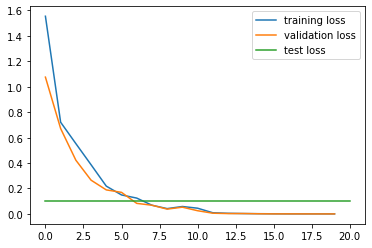

In [0]:
import matplotlib.pyplot as plt
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.plot((0,20),(results['test_loss'],results['test_loss']))

plt.legend(['training loss', 'validation loss','test loss'])

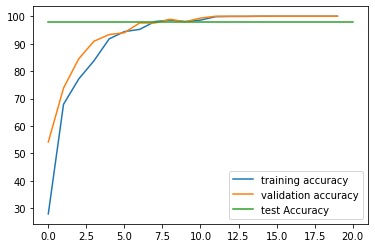

In [0]:
plt.plot(results['train_acc'])
plt.plot(results['val_acc'])
plt.plot((0,20),(results['test_acc'],results['test_acc']))
plt.legend(['training accuracy', 'validation accuracy','test Accuracy'])


In [0]:
def predict_category(text,Field_TEXT,Field_LABEL,classifier):
    preprocessed_sample = [Field_TEXT.preprocess(sample)]
    processed_sample = Field_TEXT.process(preprocessed_sample).to(args.device)
    y_pred = classifier(processed_sample)
    y_pred_np = y_pred.to(torch.device("cpu")).detach().numpy()

    return Field_LABEL.vocab.itos[np.argmax(y_pred_np)]


In [0]:
sample = "The merger did not work out"
predict_category(sample,Field_TEXT,Field_LABEL,classifier)

'sport'

In [0]:
sample = "India won by 7 wickets"
predict_category(sample,Field_TEXT,Field_LABEL,classifier)

'sport'

# *****************   End of NoteBook *****************